In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns

In [2]:
df=pd.read_csv('../input/paysim1/PS_20174392719_1491204439457_log.csv')
print(df.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [3]:
df.isnull().values.any()

False

In [4]:
transfer=df.loc[(df.isFraud==1) & (df.type=='TRANSFER')]
cash_out=df.loc[(df.isFraud==1) & (df.type=='CASH_OUT')]
print('Fraudulent Transfers',len(transfer))
print('Fraudulent Cash Outs',len(cash_out))

Fraudulent Transfers 4097
Fraudulent Cash Outs 4116


In [5]:
print(df.loc[df.isFlaggedFraud==1].type.drop_duplicates())

2736446    TRANSFER
Name: type, dtype: object


In [6]:
print("Transfers where isFraud is set",len(transfer))
print("Tranfers where isFlaggedFraud set",len(df.loc[df.isFlaggedFraud==1]))

Transfers where isFraud is set 4097
Tranfers where isFlaggedFraud set 16


In [7]:
dftype=df.loc[df.type=='TRANSFER']
flag_set=dftype.loc[dftype.isFlaggedFraud==1]
flag_not_set=dftype.loc[dftype.isFlaggedFraud==0]
amt_flag_unset=flag_not_set.amount.max()
print("Max amount transfered when isFlaggedFraud is not set",amt_flag_unset)

Max amount transfered when isFlaggedFraud is not set 92445516.64


In [8]:
old_balance=dftype.loc[dftype.isFlaggedFraud==1].oldbalanceDest.drop_duplicates()
new_balance=dftype.loc[dftype.isFlaggedFraud==1].newbalanceDest.drop_duplicates()
print(old_balance)
print(new_balance)

2736446    0.0
Name: oldbalanceDest, dtype: float64
2736446    0.0
Name: newbalanceDest, dtype: float64


In [9]:
print(len(dftype.loc[(dftype.isFlaggedFraud==0) & (dftype.oldbalanceDest==dftype.newbalanceDest)]))

4158


In [10]:
print(flag_set.oldbalanceOrg.min(),flag_set.oldbalanceOrg.max())
print(flag_not_set.loc[flag_not_set.oldbalanceOrg==flag_not_set.newbalanceOrig].oldbalanceOrg.min(),flag_not_set.loc[flag_not_set.oldbalanceOrg==flag_not_set.newbalanceOrig].oldbalanceOrg.max())

353874.22 19585040.37
0.0 575667.54


In [11]:
print("isFlaggedFraud is set and no duplicates",len(df.loc[df.isFlaggedFraud==1].nameOrig.drop_duplicates()))
print("Number of duplicates when isFlaggedFraud is not set",len(df.loc[df.isFlaggedFraud==0].nameOrig)-len(df.loc[df.isFlaggedFraud==0].nameOrig.drop_duplicates()))

isFlaggedFraud is set and no duplicates 16
Number of duplicates when isFlaggedFraud is not set 9313


Since there does not exist any correlation between isFlaggedFraud and other variables, we can treat this feature as insignificant and discard it from the dataset without any loss.

In [12]:
print("Cash in transactions where merchant pays")
print(df.loc[df.type=='CASH_IN'].nameOrig.str.contains('M').any())

Cash in transactions where merchant pays
False


In [13]:
print("Cash out transactions where the merchant is paid")
print(df.loc[df.type=='CASH_OUT'].nameDest.str.contains('M').any())

Cash out transactions where the merchant is paid
False


In [14]:
print("Are there merchants in originator accounts",df.nameOrig.str.contains('M').any())

Are there merchants in originator accounts False


In [15]:
print("Are there merchants in destination accounts except Payment",df.loc[df.type!='PAYMENT'].nameDest.str.contains('M').any())

Are there merchants in destination accounts except Payment False


The merchants occur in an unexpected way

In [16]:
fraud=transfer.nameDest.isin(cash_out.nameOrig).any()
print(fraud)

False


The data is not in accordance with the modus operandi

In [17]:
notfraud=df.loc[df.isFraud==0]
print(transfer.loc[transfer.nameDest.isin(notfraud.loc[notfraud.type=='CASH_OUT'].nameOrig.drop_duplicates())])

         step      type      amount     nameOrig  oldbalanceOrg  \
1030443    65  TRANSFER  1282971.57  C1175896731     1282971.57   
6039814   486  TRANSFER   214793.32  C2140495649      214793.32   
6362556   738  TRANSFER   814689.88  C2029041842      814689.88   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
1030443             0.0  C1714931087             0.0             0.0        1   
6039814             0.0   C423543548             0.0             0.0        1   
6362556             0.0  C1023330867             0.0             0.0        1   

         isFlaggedFraud  
1030443               0  
6039814               0  
6362556               0  


In [18]:
print("fraudulent tranfer to C423543548 occurs at step 486 and cashout from this account occurs at step",notfraud.loc[(notfraud.type=='CASH_OUT') & (notfraud.nameOrig=="C423543548")].step.values)

fraudulent tranfer to C423543548 occurs at step 486 and cashout from this account occurs at step [185]


Since it is observed that the above account does a genuine cash out at a later step but receives a fraudulent transfer before that, fraudulent transactions are not indicated by nameOrig and nameDest variables


In [19]:
X=df.loc[(df.type=='TRANSFER') | (df.type=='CASH_OUT')]
X=X.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1)
Y=X['isFraud']

In [20]:
X.loc[X.type=='TRANSFER','type']=0
X.loc[X.type=='CASH_OUT','type']=1
X.type=X.type.astype(int)

In [21]:
X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,1,0,181.00,181.0,0.0,0.0,0.00,1
3,1,1,181.00,181.0,0.0,21182.0,0.00,1
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44,0
19,1,0,215310.30,705.0,0.0,22425.0,0.00,0
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89,0


In [22]:
Xfraud=X.loc[Y==1]
Xnonfraud=X.loc[Y==0]

In [23]:
print("The fraction of fraudulent transactions with oldbalanceDest= newbalanceDest= 0 although the transacted amount is non-zero is:\n",len(Xfraud.loc[(Xfraud.oldbalanceDest==0) & (Xfraud.newbalanceDest==0)])/len(Xfraud))

The fraction of fraudulent transactions with oldbalanceDest= newbalanceDest= 0 although the transacted amount is non-zero is:
 0.49628637525873615


In [24]:
print("The fraction of genuine transactions with oldbalanceDest= newbalanceDest= 0 although the transacted amount is non-zero is:\n",len(Xnonfraud.loc[(X.oldbalanceDest==0) & (X.newbalanceDest==0)])/len(Xnonfraud))

The fraction of genuine transactions with oldbalanceDest= newbalanceDest= 0 although the transacted amount is non-zero is:
 0.0006176245277308345


In [25]:
print("The fraction of fraudulent transactions with oldbalanceOrg= newbalanceOrig= 0 although the transacted amount is non-zero is:\n",len(Xfraud.loc[(Xfraud.oldbalanceOrg==0) & (Xfraud.newbalanceOrig==0)])/len(Xfraud))

The fraction of fraudulent transactions with oldbalanceOrg= newbalanceOrig= 0 although the transacted amount is non-zero is:
 0.00499208571776452


In [26]:
print("The fraction of genuine transactions with oldbalanceOrg= newbalanceOrig= 0 although the transacted amount is non-zero is:\n",len(Xnonfraud.loc[(Xnonfraud.oldbalanceOrg==0) & (Xnonfraud.newbalanceOrig==0)])/len(Xnonfraud))

The fraction of genuine transactions with oldbalanceOrg= newbalanceOrig= 0 although the transacted amount is non-zero is:
 0.4737321319703598


In [27]:
X.loc[(X.oldbalanceDest==0) & (X.newbalanceDest==0) & (X.amount!=0),['oldbalanceDest','newbalanceDest']]=-1
X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,1,0,181.00,181.0,0.0,-1.0,-1.00,1
3,1,1,181.00,181.0,0.0,21182.0,0.00,1
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44,0
19,1,0,215310.30,705.0,0.0,22425.0,0.00,0
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89,0


In [28]:
X.loc[(X.oldbalanceOrg==0) & (X.newbalanceOrig==0) & (X.amount!=0),['oldbalanceOrg','newbalanceOrig']]=np.nan

In [29]:
X['errorBalOrig']=X.oldbalanceOrg+X.amount-X.newbalanceOrig
X['errorBalDest']=X.oldbalanceDest+X.amount-X.newbalanceDest

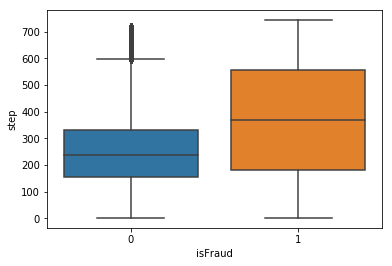

In [30]:
sns.boxplot(x='isFraud',y='step',data=X)